In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import graphviz
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
def perf_eval(cm, y_true, y_pred_proba):
  _tp = cm[1, 1]
  _fn = cm[1, 0]
  _fp = cm[0, 1]
  _tn = cm[0, 0]
  # True positive rate: TPR (Recall)
  TPR = _tp / (_tp + _fn)
  # Precision
  PRE = _tp/(_tp+_fp)
  # True negative rate: TNR
  TNR = _tn/(_tn+_fp)
  # Simple Accuracy
  ACC = (_tp + _tn) / np.sum(cm)
  # Balanced Correction Rate
  BCR = np.sqrt(TPR*TNR)
  # F1-Measure
  F1 = 2*TPR*PRE/(TPR+PRE)
  # AUROC
  AUROC = roc_auc_score(y_true, y_pred_proba)
  return TPR, PRE, TNR, ACC, BCR, F1, AUROC


In [ ]:
# Performance table
Perf_Table = pd.DataFrame(index=["Full Tree", "Post-Pruning", "Pre-Pruning"],columns = ["TPR", "Precision", "TNR","Accuracy", "BCR", "F1-Measure", "AUROC"])
print(Perf_Table)

              TPR Precision  TNR Accuracy  BCR F1-Measure AUROC
Full Tree     NaN       NaN  NaN      NaN  NaN        NaN   NaN
Post-Pruning  NaN       NaN  NaN      NaN  NaN        NaN   NaN
Pre-Pruning   NaN       NaN  NaN      NaN  NaN        NaN   NaN


In [ ]:
#데이터 전처리
employee_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/riceClassification.csv")
print(employee_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               18185 non-null  int64  
 1   Area             18185 non-null  int64  
 2   MajorAxisLength  18185 non-null  float64
 3   MinorAxisLength  18185 non-null  float64
 4   Eccentricity     18185 non-null  float64
 5   ConvexArea       18185 non-null  int64  
 6   EquivDiameter    18185 non-null  float64
 7   Extent           18185 non-null  float64
 8   Perimeter        18185 non-null  float64
 9   Roundness        18185 non-null  float64
 10  AspectRation     18185 non-null  float64
 11  Class            18185 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.7 MB
None


In [ ]:
#명목형 변수 데이터 구성 파악
employee_df['Education'].value_counts()

Education
Bachelors    3601
Masters       873
PHD           179
Name: count, dtype: int64

In [ ]:
employee_df['City'].value_counts()

City
Bangalore    2228
Pune         1268
New Delhi    1157
Name: count, dtype: int64

In [ ]:
employee_df['Gender'].value_counts()

Gender
Male      2778
Female    1875
Name: count, dtype: int64

In [ ]:
employee_df['EverBenched'].value_counts()

EverBenched
No     4175
Yes     478
Name: count, dtype: int64

In [ ]:
#Education, Gender, Everbencehd 열 라벨링 인코딩

# 라벨 인코딩 사전 정의
education_mapping = {'Bachelors': 1, 'Masters': 2, 'PHD': 3}
gender_mapping = {'Male': 1, 'Female': 0}
ever_benched_mapping = {'Yes': 1, 'No': 0}

# 각 열을 숫자로 변환
employee_df['Education'] = employee_df['Education'].map(education_mapping)
employee_df['Gender'] = employee_df['Gender'].map(gender_mapping)
employee_df['EverBenched'] = employee_df['EverBenched'].map(ever_benched_mapping)

# `City` 열에 대해 원-핫 인코딩 수행
employee_df = pd.get_dummies(employee_df, columns=['City'])

# 변경된 데이터프레임의 첫 몇 행을 출력하여 확인합니다
print(employee_df)

      Education  JoiningYear  PaymentTier  Age  Gender  EverBenched  \
0             1         2017            3   34       1            0   
1             1         2013            1   28       0            0   
2             1         2014            3   38       0            0   
3             2         2016            3   27       1            0   
4             2         2017            3   24       1            1   
...         ...          ...          ...  ...     ...          ...   
4648          1         2013            3   26       0            0   
4649          2         2013            2   37       1            0   
4650          2         2018            3   27       1            0   
4651          1         2012            3   30       1            1   
4652          1         2015            3   33       1            1   

      ExperienceInCurrentDomain  LeaveOrNot  City_Bangalore  City_New Delhi  \
0                             0           0            True         

In [ ]:
#스케일링 작업 수행행
from sklearn.preprocessing import StandardScaler

# 스케일링을 제외할 열 목록
exclude_columns = ['Education', 'Gender', 'EverBenched', 'LeaveOrNot'] + [col for col in employee_df.columns if col.startswith('City_')]

# 스케일링할 열 목록
scale_columns = [col for col in employee_df.columns if col not in exclude_columns]

# 스케일러 초기화
scaler = StandardScaler()

# 스케일링 적용
employee_df[scale_columns] = scaler.fit_transform(employee_df[scale_columns])

# 변경된 데이터프레임의 첫 몇 행을 출력하여 확인합니다
print(employee_df.head())

   Education  JoiningYear  PaymentTier       Age  Gender  EverBenched  \
0          1     1.039638     0.537503  0.954645       1            0   
1          1    -1.107233    -3.025177 -0.288732       0            0   
2          1    -0.570515     0.537503  1.783563       0            0   
3          2     0.502921     0.537503 -0.495961       1            0   
4          2     1.039638     0.537503 -1.117650       1            1   

   ExperienceInCurrentDomain  LeaveOrNot  City_Bangalore  City_New Delhi  \
0                  -1.864901           0            True           False   
1                   0.060554           1           False           False   
2                  -0.581264           0           False            True   
3                   1.344191           1            True           False   
4                  -0.581264           1           False           False   

   City_Pune  
0      False  
1       True  
2      False  
3      False  
4       True  


In [ ]:
#결측치 존재성 확인
missing_values = employee_df.isnull().sum()
print(missing_values)

Education                    0
JoiningYear                  0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
City_Bangalore               0
City_New Delhi               0
City_Pune                    0
dtype: int64


In [ ]:
#데이터셋 분할

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

x=employee_df.drop(columns=['LeaveOrNot'])
y=employee_df['LeaveOrNot']

x_train, x_temp, y_train, y_temp=train_test_split(x, y, test_size=0.3, random_state=12345)
x_val, x_test, y_val, y_test=train_test_split(x_temp, y_temp, test_size=0.5, random_state=12345)

In [ ]:
# Classification and Regression Tree (CART) --------------------------------------
# Full Tree 학습 및 성능 평가
clf=DecisionTreeClassifier(random_state=12345)
clf.fit(x_train, y_train)
y_pred_full=clf.predict(x_test)
y_pred_proba_full = clf.predict_proba(x_test)[:, 1]  # Positive class 확률

# 트리 깊이 확인
tree_depth = clf.get_depth()
print(f"Tree Depth: {tree_depth}")

# 리프 노드 개수 확인
num_leaves = clf.tree_.n_leaves
print(f"Number of Leaf Nodes: {num_leaves}")

cm_full=confusion_matrix(y_test, y_pred_full)
perf_full=perf_eval(cm_full, y_test
                    , y_pred_proba_full)

Perf_Table.iloc[0]=perf_full
print(Perf_Table)

Tree Depth: 23
Number of Leaf Nodes: 670
                   TPR Precision       TNR  Accuracy       BCR F1-Measure  \
Full Tree     0.669604    0.7343  0.883227  0.813754  0.769033   0.700461   
Post-Pruning       NaN       NaN       NaN       NaN       NaN        NaN   
Pre-Pruning        NaN       NaN       NaN       NaN       NaN        NaN   

                 AUROC  
Full Tree     0.790969  
Post-Pruning       NaN  
Pre-Pruning        NaN  


In [ ]:
#Post-Pruning(사후적 가지치기)

path=clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities= path.ccp_alphas, path.impurities

# 알파 값에 따른 Validation 데이터에 대한 Accuracy 계산 후 최적의 알파 값 결정
val_accs = []

for alpha in ccp_alphas:
  pruned_tree=DecisionTreeClassifier(random_state=12345, ccp_alpha=alpha)
  pruned_tree.fit(x_train, y_train)
  val_acc=pruned_tree.score(x_val,y_val)
  val_accs.append(val_acc)

best_alpha=ccp_alphas[val_accs.index(max(val_accs))]

optimal_tree=DecisionTreeClassifier(random_state=12345, ccp_alpha=best_alpha)
optimal_tree.fit(x_train, y_train)

# 말단 노드 개수 확인
num_leaves = optimal_tree.get_n_leaves()
print(f"Number of leaf nodes: {num_leaves}")

y_pred_post=optimal_tree.predict(x_test)
y_pred_proba_post = optimal_tree.predict_proba(x_test)[:, 1]  # Positive class 확률
cm_post=confusion_matrix(y_test, y_pred_post)
perf_post=perf_eval(cm_post, y_test, y_pred_proba_post)

Perf_Table.iloc[1]=perf_post
print(Perf_Table)




Number of leaf nodes: 29
                   TPR Precision       TNR  Accuracy       BCR F1-Measure  \
Full Tree     0.669604    0.7343  0.883227  0.813754  0.769033   0.700461   
Post-Pruning  0.726872  0.850515  0.938429  0.869628  0.825904   0.783848   
Pre-Pruning        NaN       NaN       NaN       NaN       NaN        NaN   

                 AUROC  
Full Tree     0.790969  
Post-Pruning  0.872106  
Pre-Pruning        NaN  


In [ ]:
#사후적 가지치기
# 사용된 변수의 인덱스
used_features_indices = np.nonzero(optimal_tree.tree_.feature >= 0)[0]
used_features = set(optimal_tree.tree_.feature[used_features_indices])

# 변수명 추출
used_feature_names = [x.columns[i] for i in used_features]

print(f"분기에 사용된 변수 수: {len(used_features)}")
print("사용된 변수 인덱스:", used_features)
print("사용된 변수명:", used_feature_names)

분기에 사용된 변수 수: 10
사용된 변수 인덱스: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
사용된 변수명: ['Education', 'JoiningYear', 'PaymentTier', 'Age', 'Gender', 'EverBenched', 'ExperienceInCurrentDomain', 'City_Bangalore', 'City_New Delhi', 'City_Pune']


In [ ]:
#Pre-Prunning(사전적 가지치기)

criterion = ['gini', 'entropy']
max_depth = [None, 5, 10, 20]
min_split = [2, 5, 10]
min_leaf = [1, 2, 4]

param_grid = {'criterion': criterion, 'min_samples_split': min_split, 'max_depth': max_depth,  'min_samples_leaf': min_leaf}

from sklearn.model_selection import ParameterGrid

best_auroc=0.0
best_model_pre=None

for params in ParameterGrid(param_grid):
  model=DecisionTreeClassifier(**params, random_state=12345)
  model.fit(x_train, y_train)
  y_val_pred=model.predict(x_val)
  auroc=roc_auc_score(y_val, model.predict_proba(x_val)[:,1])
  if auroc>best_auroc:
    best_auroc=auroc
    best_model_pre=model

y_test_pred=best_model_pre.predict(x_test)
y_test_proba = best_model_pre.predict_proba(x_test)[:, 1]
test_auroc=roc_auc_score(y_test, best_model_pre.predict_proba(x_test)[:,1])

print(best_model_pre.get_params())
print(test_auroc)

# 말단 노드 개수 확인
num_leaves = best_model_pre.get_n_leaves()
print(f"Number of leaf nodes: {num_leaves}")

# 성능 평가
cm_pre = confusion_matrix(y_test, y_test_pred)
perf_pre = perf_eval(cm_pre, y_test, y_test_proba)

# 성능 테이블에 추가
Perf_Table.iloc[2] = perf_pre
print(Perf_Table)


{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': 12345, 'splitter': 'best'}
0.8596481382754846
Number of leaf nodes: 18
                   TPR Precision       TNR  Accuracy       BCR F1-Measure  \
Full Tree     0.669604    0.7343  0.883227  0.813754  0.769033   0.700461   
Post-Pruning  0.726872  0.850515  0.938429  0.869628  0.825904   0.783848   
Pre-Pruning   0.621145  0.844311  0.944798  0.839542  0.766066   0.715736   

                 AUROC  
Full Tree     0.790969  
Post-Pruning  0.872106  
Pre-Pruning   0.859648  


In [ ]:
#사전적 가지치기
# 사용된 변수의 인덱스 (양수인 것만 세면 됩니다)
used_features_indices = np.nonzero(best_model_pre.tree_.feature >= 0)[0]
used_features = set(best_model_pre.tree_.feature[used_features_indices])

# 변수명 추출
used_feature_names = [x.columns[i] for i in used_features]

print(f"분기에 사용된 변수 수: {len(used_features)}")
print("사용된 변수 인덱스:", used_features)
print("사용된 변수명:", used_feature_names)

분기에 사용된 변수 수: 9
사용된 변수 인덱스: {0, 1, 2, 3, 4, 5, 7, 8, 9}
사용된 변수명: ['Education', 'JoiningYear', 'PaymentTier', 'Age', 'Gender', 'EverBenched', 'City_Bangalore', 'City_New Delhi', 'City_Pune']


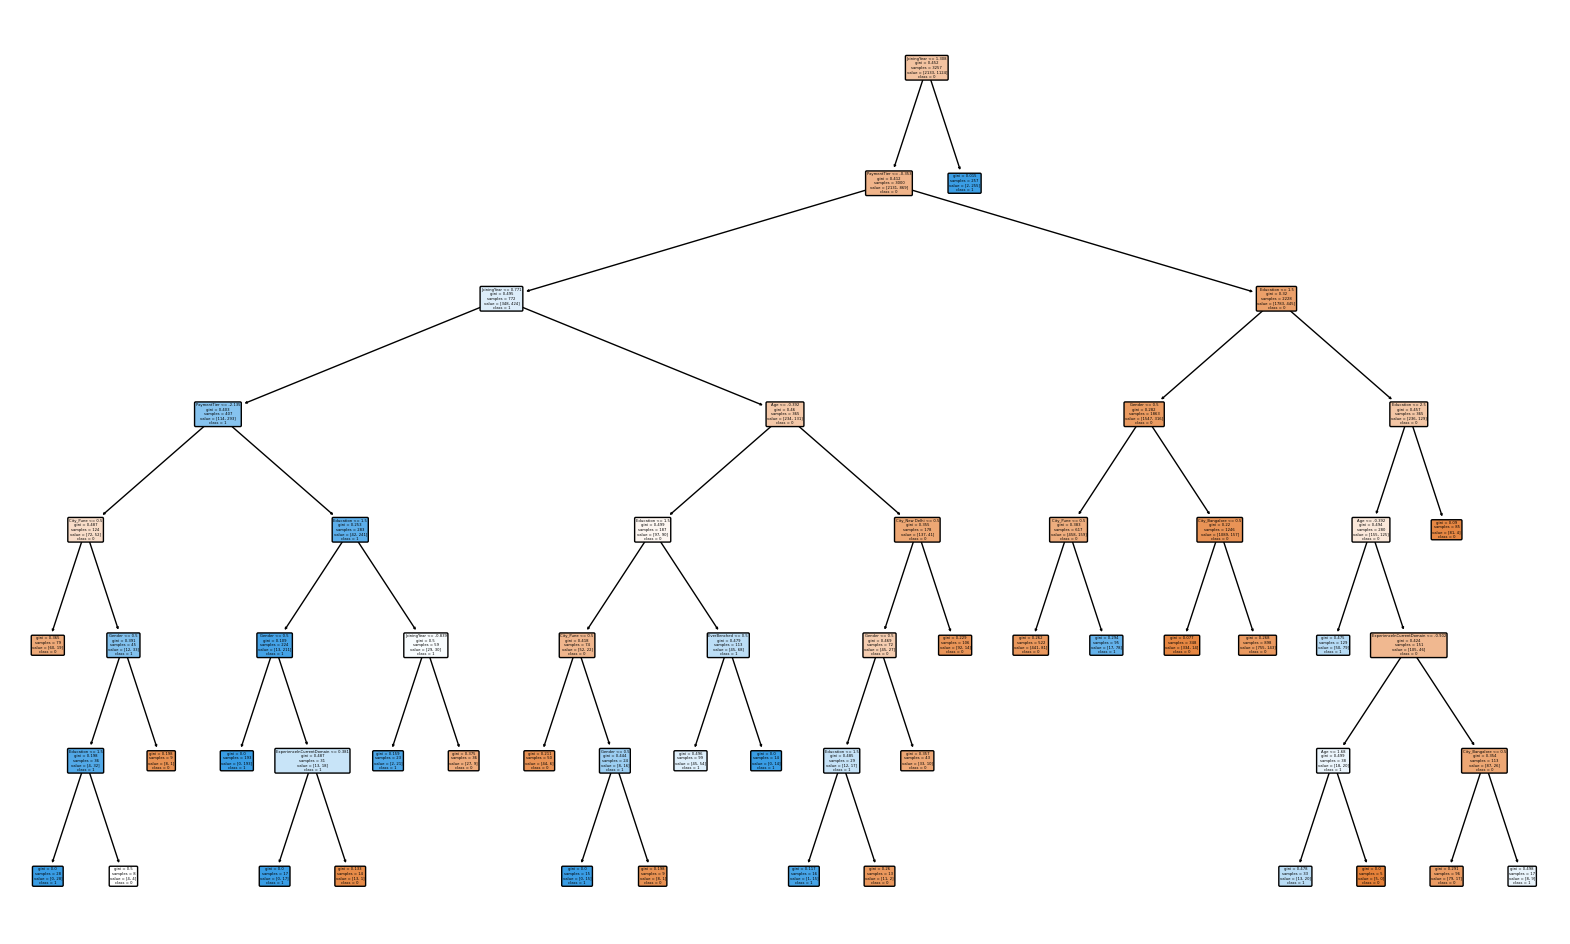

In [ ]:
#사후적 가지치기 plot
from sklearn.tree import plot_tree
plt.figure(figsize=(20,12))
plot_tree(optimal_tree, feature_names=x.columns, class_names=['0', '1'], rounded=True, filled=True)
plt.savefig("optimal_tree.pdf") #pdf로 저장
plt.show()

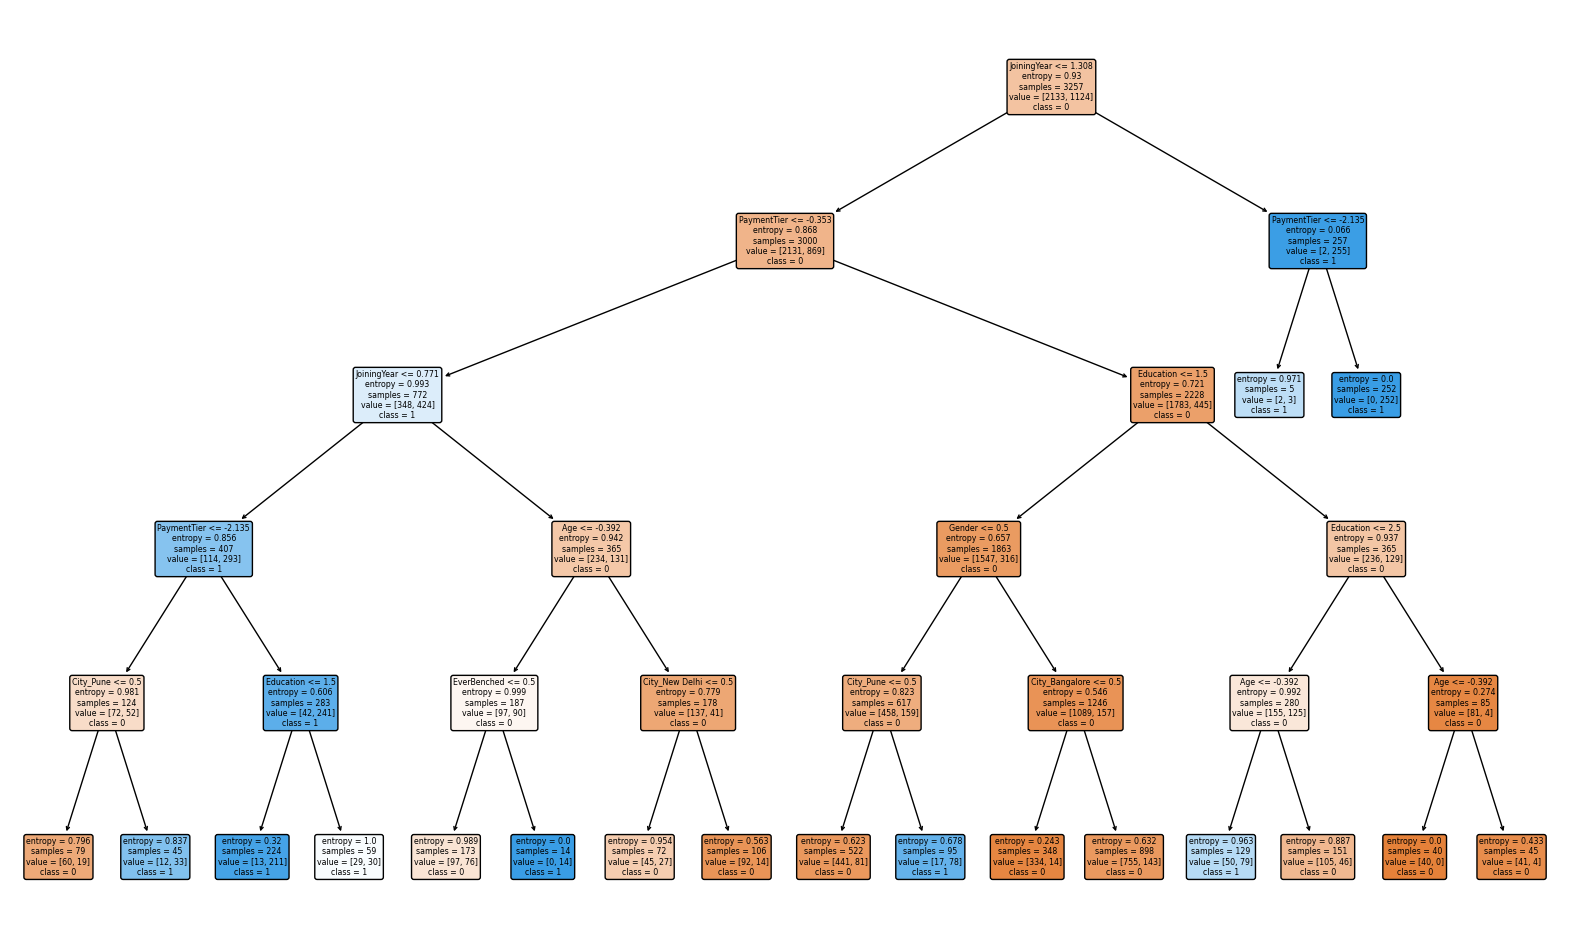

In [ ]:
#사전적 가지치기 plot
plt.figure(figsize=(20,12))
plot_tree(best_model_pre, feature_names=x.columns, class_names=['0', '1'], rounded=True, filled=True)
plt.savefig("best_model_pre.pdf") #pdf로 저장
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
def perf_eval(cm):
  _tp = cm[1, 1]
  _fn = cm[1, 0]
  _fp = cm[0, 1]
  _tn = cm[0, 0]
  # True positive rate: TPR (Recall)
  TPR = _tp / (_tp + _fn)
  # Precision
  PRE = _tp/(_tp+_fp)
  # True negative rate: TNR
  TNR = _tn/(_tn+_fp)
  # Simple Accuracy
  ACC = (_tp + _tn) / np.sum(cm)
  # Balanced Correction Rate
  BCR = np.sqrt(TPR*TNR)
  # F1-Measure
  F1 = 2*TPR*PRE/(TPR+PRE)
  # AUROC
  return TPR, TNR, ACC, BCR, F1

# Performance table
Perf_Table = pd.DataFrame(index=["Logistic Regression", "Decision Tree", "Neural Network"],columns = ["TPR", "TNR","Accuracy", "BCR", "F1-Measure"])
print(Perf_Table)

                     TPR  TNR Accuracy  BCR F1-Measure
Logistic Regression  NaN  NaN      NaN  NaN        NaN
Decision Tree        NaN  NaN      NaN  NaN        NaN
Neural Network       NaN  NaN      NaN  NaN        NaN


In [ ]:
#최적의 파라미터 찾기(ANN)

param_grid_q6 = {'hidden_layer_sizes': [(50,), (100,), (200,)],
                 'activation': ['relu', 'tanh', 'logistic'],
                 'solver': ['adam', 'sgd', 'lbfgs'],
                 'learning_rate':['constant', 'invscaling', 'adaptive'],
                 'max_iter':[100,200,500]}


best_auroc=0.0
best_model_ann=None

for params in ParameterGrid(param_grid_q6):
  model=MLPClassifier(**params, random_state=12345)
  model.fit(x_train, y_train)
  y_val_=model.predict(x_val)
  auroc=roc_auc_score(y_val, model.predict_proba(x_val)[:,1])
  if auroc>best_auroc:
    best_auroc=auroc
    best_model_ann=model

y_test_pred=best_model_ann.predict(x_test)
test_auroc_ann=roc_auc_score(y_test, best_model_ann.predict_proba(x_test)[:,1])

print(best_model_ann.get_params())
print(test_auroc_ann)

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 100, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 12345, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
0.8526193215297847


In [ ]:
# 혼동 행렬 계산
cm_ann = confusion_matrix(y_test, y_test_pred)
# ANN 모델의 성능 지표 계산
TPR, TNR, ACC, BCR, F1 = perf_eval(cm_ann)

# Perf_Table에 값 추가
Perf_Table.loc["Neural Network"] = [TPR, TNR, ACC, BCR, F1]

print(Perf_Table)

                          TPR       TNR  Accuracy       BCR F1-Measure
Logistic Regression       NaN       NaN       NaN       NaN        NaN
Decision Tree             NaN       NaN       NaN       NaN        NaN
Neural Network       0.590308  0.963907  0.842407  0.754322   0.708995


In [ ]:
#최적의 파라미터 찾기(LR)

param_grid_q7 = {'penalty': ['l1', 'l2'],
                 'C': [0.001, 0.01, 0.1, 1, 10],
                 'solver':['liblinear', 'saga'],
                 'max_iter':[100, 200, 500]
                 }


best_auroc_logi=0.0
best_model_logi=None

for params in ParameterGrid(param_grid_q7):
  model=LogisticRegression(**params, random_state=12345)
  model.fit(x_train, y_train)
  y_val_logi=model.predict(x_val)
  auroc=roc_auc_score(y_val, model.predict_proba(x_val)[:,1])
  if auroc>best_auroc_logi:
    best_auroc_logi=auroc
    best_model_logi=model

y_test_pred=best_model_logi.predict(x_test)
test_auroc_logi=roc_auc_score(y_test, best_model_logi.predict_proba(x_test)[:,1])

print(best_model_logi.get_params())
print(test_auroc_logi)

{'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 12345, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.7347708970509834


In [ ]:
# 혼동 행렬 계산
cm_logistic = confusion_matrix(y_test, y_test_pred)
# 로지스틱 회귀 모델의 성능 지표 계산
TPR, TNR, ACC, BCR, F1 = perf_eval(cm_logistic)

# Perf_Table에 값 추가
Perf_Table.loc["Logistic Regression"] = [TPR, TNR, ACC, BCR, F1]

print(Perf_Table)

                          TPR       TNR  Accuracy       BCR F1-Measure
Logistic Regression  0.462555  0.887473  0.749284  0.640707   0.545455
Decision Tree             NaN       NaN       NaN       NaN        NaN
Neural Network       0.590308  0.963907  0.842407  0.754322   0.708995
